In [ ]:
import os
import requests
import zipfile
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/tanjemahamed/odir5k-classification/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: prashantmishra2003
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tanjemahamed/odir5k-classification


In [ ]:
# # Define Dataset Class for ODIR-5K
# class ODIRDatasetSSL(Dataset):
#     def __init__(self, image_dir, transform=None):
#         self.image_dir = image_dir
#         self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.image_dir, self.image_files[idx])
#         img = Image.open(img_path).convert('RGB')  # Convert grayscale images to RGB if necessary
#         if self.transform:
#             img_0 = self.transform(img)  # Original image
#             img_1 = self.transform(img)  # Augmented image
#         label_0 = 0  # Transformation label 0
#         label_1 = 1  # Transformation label 1
#         return img_0, label_0, img_1, label_1

In [ ]:
# # Transformation and Augmentation for SSL
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(90),
#     transforms.ToTensor()
# ])

In [ ]:
# Images to dataframes with respective labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [ ]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [ ]:
data_dir = '/content/odir5k-classification/datasets'


try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 5113 validated image filenames belonging to 8 classes.
Found 639 validated image filenames belonging to 8 classes.
Found 640 validated image filenames belonging to 8 classes.


In [ ]:
train_gen.image_shape

(224, 224, 3)

In [ ]:
print(train_df.shape)
print(valid_df)
print(test_df.shape)

(5113, 2)
                                              filepaths    labels
3086  /content/odir5k-classification/datasets/catara...  cataract
341   /content/odir5k-classification/datasets/diabet...  diabetes
4983  /content/odir5k-classification/datasets/normal...    normal
1801  /content/odir5k-classification/datasets/others...    others
6208  /content/odir5k-classification/datasets/myopia...    myopia
...                                                 ...       ...
4020  /content/odir5k-classification/datasets/normal...    normal
4232  /content/odir5k-classification/datasets/normal...    normal
1078  /content/odir5k-classification/datasets/diabet...  diabetes
3215  /content/odir5k-classification/datasets/catara...  cataract
5152  /content/odir5k-classification/datasets/normal...    normal

[639 rows x 2 columns]
(640, 2)


In [ ]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

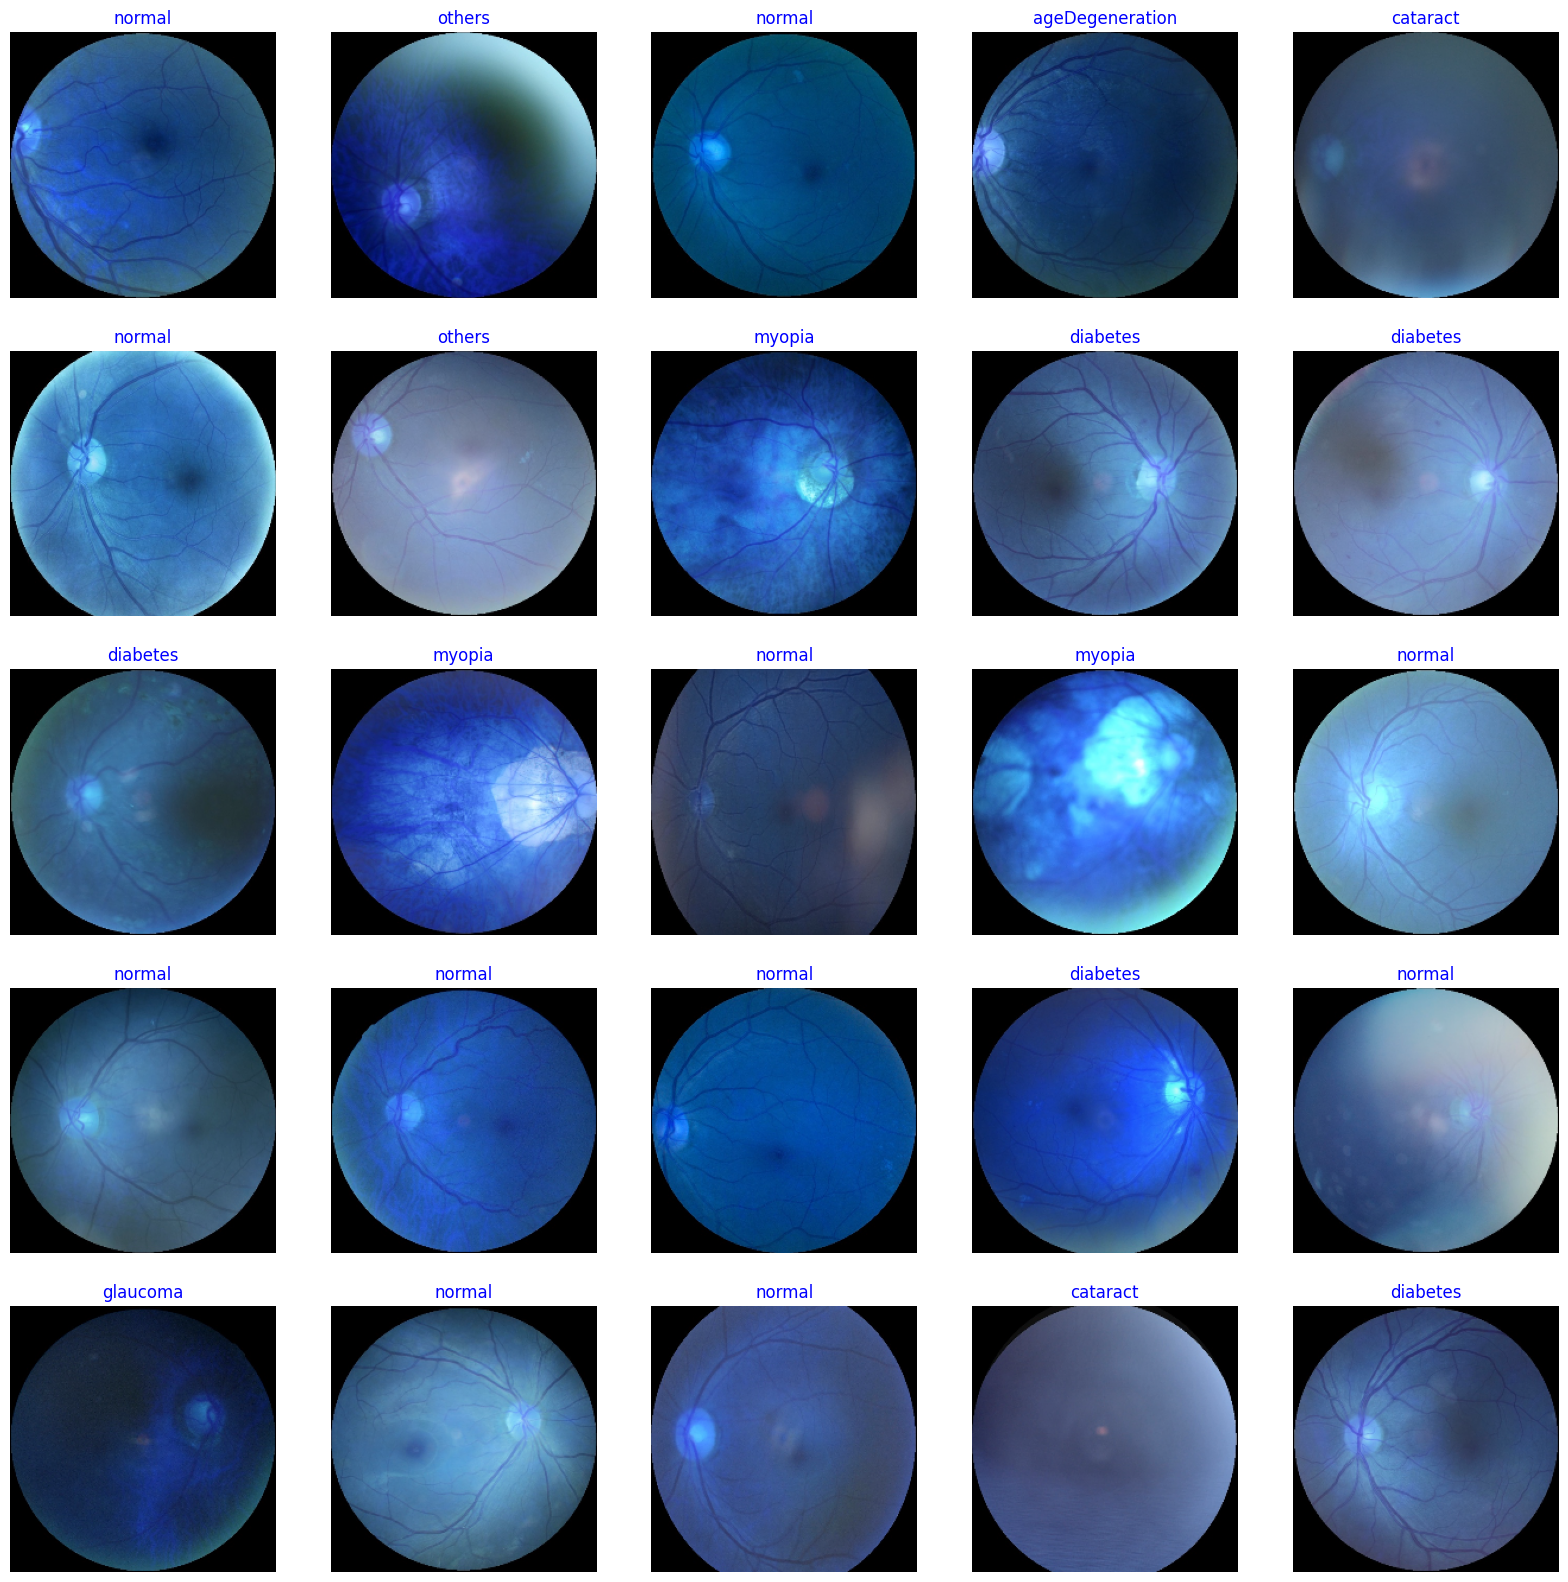

In [ ]:
show_images(train_gen)

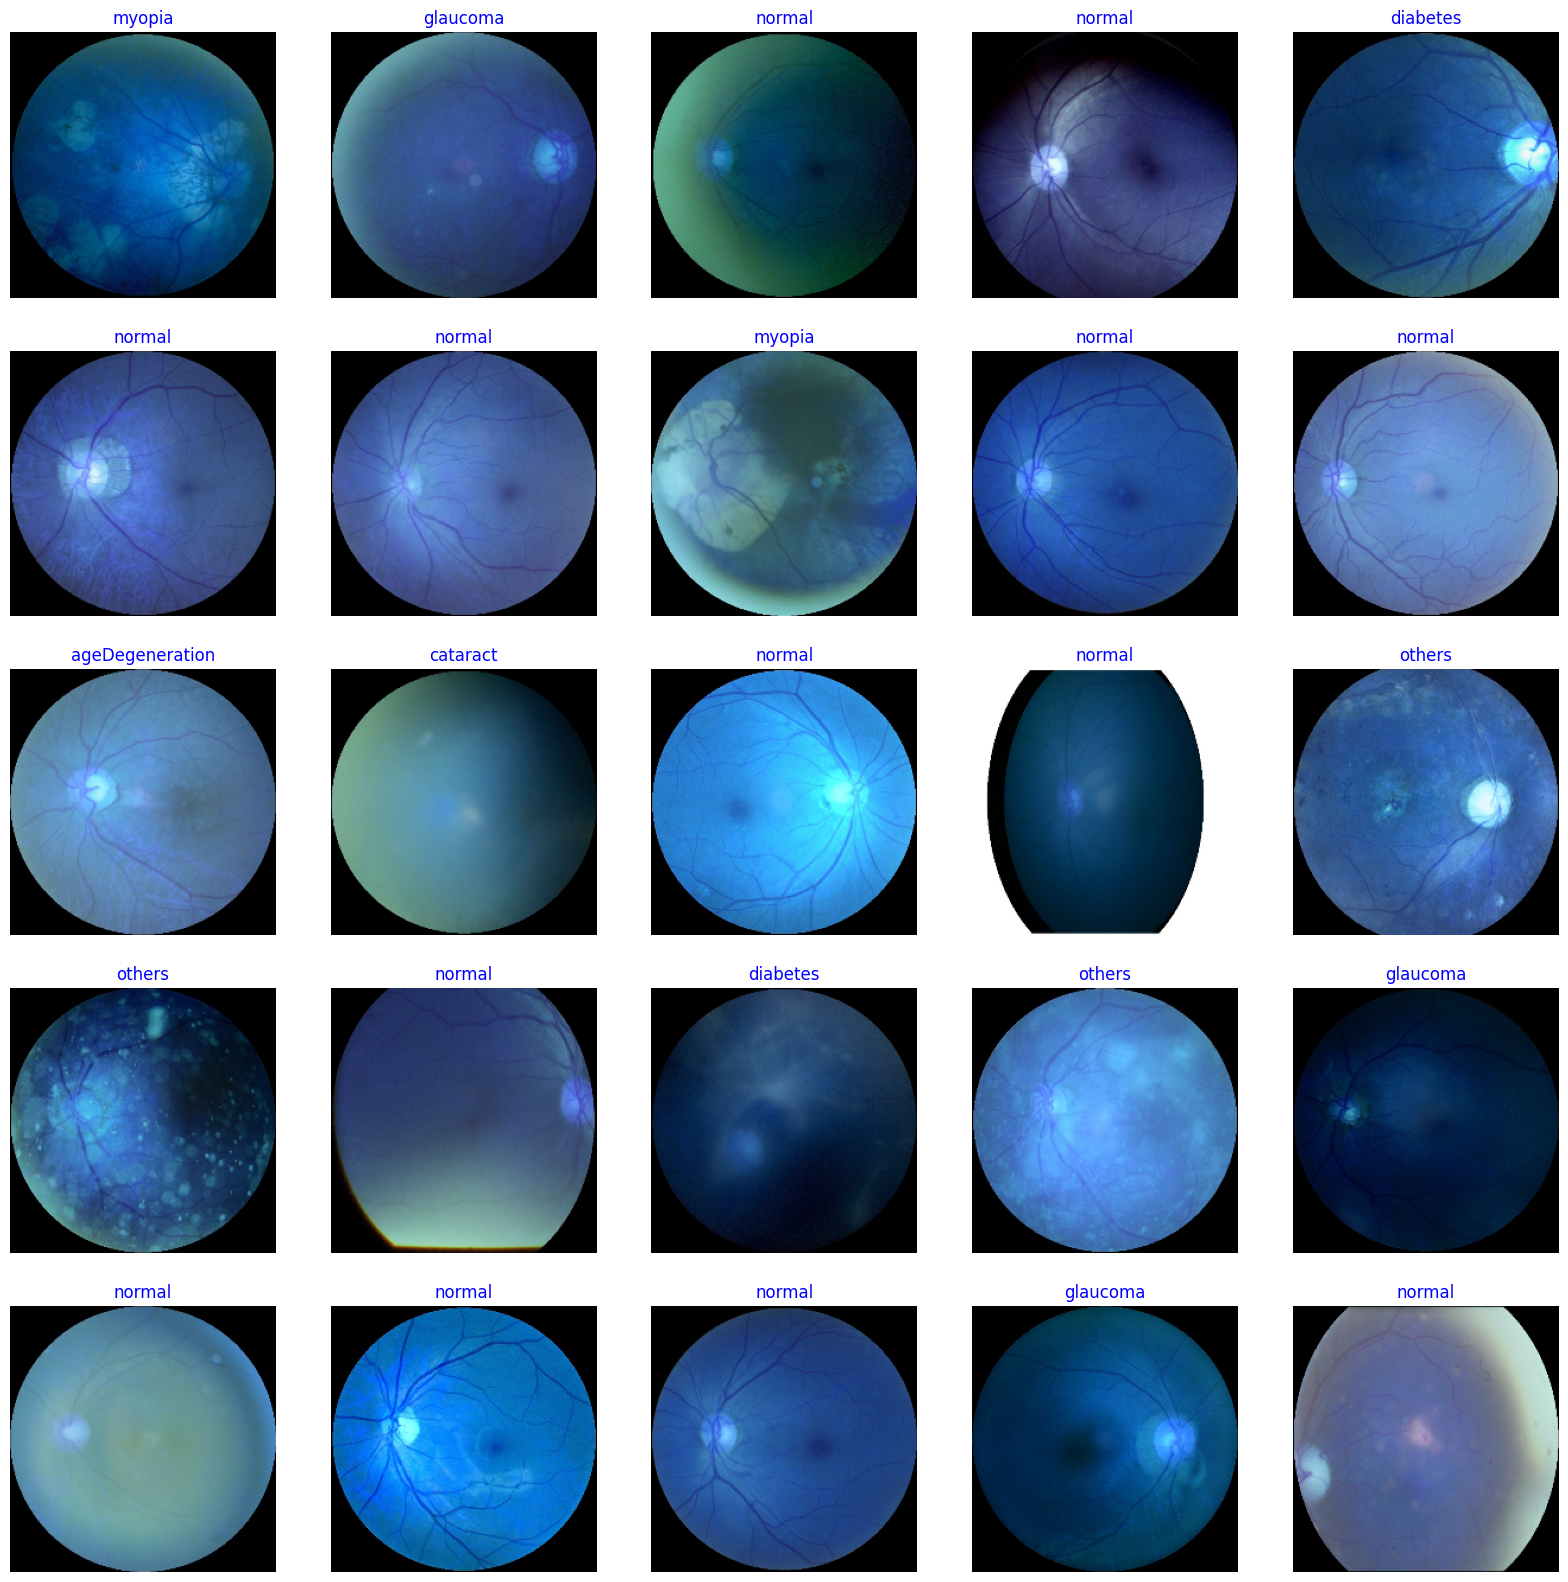

In [ ]:
show_images(test_gen)

In [ ]:
# Data Generators
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size=40)


Found 5113 validated image filenames belonging to 8 classes.
Found 639 validated image filenames belonging to 8 classes.
Found 640 validated image filenames belonging to 8 classes.


## to change

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def build_model(input_shape, num_classes):
    """
    Build and compile the model using transfer learning (ResNet50 as backbone).

    Args:
    - input_shape (tuple): Shape of input images, e.g., (224, 224, 3).
    - num_classes (int): Number of output classes.

    Returns:
    - model (Sequential): Compiled Keras model.
    """
    # Load ResNet50 as the backbone
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # # Add custom layers
    # model = Sequential([
    #     base_model,
    #     GlobalAveragePooling2D(),  # Reduces feature maps to a single vector
    #     Dense(128, activation='relu'),
    #     Dropout(0.3),  # Regularization to prevent overfitting
    #     Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
    # ]) OPTIMIZING MODEL ARCH - ABHI
    model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
    ])


    # # Freeze base model layers
    # base_model.trainable = False
    ## unfreezing the layers for optimiztion(Abhi)
    base_model.trainable = True
    for layer in base_model.layers[:100]:  # Freeze initial layers
      layer.trainable = False


    # # Compile the model
    # model.compile(
    #     optimizer=Adam(learning_rate=0.001),
    #     loss='categorical_crossentropy',
    #     metrics=['accuracy']
    # ) REDUCING LEARNING FOR OPTI(Abhi)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


    return model

# Define Input Shape and Number of Classes
img_shape = (224, 224, 3)  # RGB images
num_classes = len(train_gen.class_indices)  # Number of unique labels

# Build the Model
model = build_model(input_shape=img_shape, num_classes=num_classes)
model.summary()  # Print model architecture


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,146,184 (92.11 MB)

 Trainable params: 20,011,400 (76.34 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

#NEW MODEL

In [ ]:
def build_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Define custom layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    # Freeze the base model layers initially
    base_model.trainable = False

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define Input Shape and Number of Classes
img_shape = (224, 224, 3)  # RGB Images
num_classes = len(train_gen.class_indices)  # Number of unique classes

# Build the Model
model = build_model(input_shape=img_shape, num_classes=num_classes)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,147,720 (92.12 MB)

 Trainable params: 559,240 (2.13 MB)

 Non-trainable params: 23,588,480 (89.98 MB)

##RESNET 101


In [ ]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def build_model(input_shape, num_classes):
    """
    Build and compile the model using transfer learning (ResNet101 as backbone).

    Args:
    - input_shape (tuple): Shape of input images, e.g., (224, 224, 3).
    - num_classes (int): Number of output classes.

    Returns:
    - model (Sequential): Compiled Keras model.
    """
    # Load ResNet101 as the backbone
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add custom layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Reduces feature maps to a single vector
        Dense(128, activation='relu'),
        Dropout(0.3),  # Regularization to prevent overfitting
        Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
    ])

    # Freeze base model layers
    base_model.trainable = False

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping


def build_model(input_shape, num_classes):
    """
    Build and compile the model using transfer learning (ResNet101 as backbone).

    Args:
    - input_shape (tuple): Shape of input images, e.g., (224, 224, 3).
    - num_classes (int): Number of output classes.

    Returns:
    - model (Sequential): Compiled Keras model.
    """
    # Load ResNet101 as the backbone
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add custom layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Reduces feature maps to a single vector
        Dense(128, activation='relu'),
        Dropout(0.3),  # Regularization to prevent overfitting
        Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
    ])

    # Freeze base model layers
    base_model.trainable = False

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define Input Shape and Number of Classes
img_shape = (224, 224, 3)  # RGB images
num_classes = len(train_gen.class_indices)  # Number of unique labels

# Build the Model by calling the function
model = build_model(input_shape=img_shape, num_classes=num_classes) #This line instantiates the model by calling the function


# Early Stopping to Prevent Overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop after 3 epochs of no improvement
    restore_best_weights=True
)

# Train the Model
epochs = 15
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    steps_per_epoch=len(train_gen),
    validation_steps=len(valid_gen),
    verbose=1,
    callbacks=[early_stopping]
)

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 74s 378ms/step - accuracy: 0.4222 - loss: 1.6539 - val_accuracy: 0.5540 - val_loss: 1.2174
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 26s 205ms/step - accuracy: 0.5391 - loss: 1.2604 - val_accuracy: 0.5665 - val_loss: 1.2012
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 27s 210ms/step - accuracy: 0.5521 - loss: 1.2071 - val_accuracy: 0.5587 - val_loss: 1.1765
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 219ms/step - accuracy: 0.5627 - loss: 1.1731 - val_accuracy: 0.5696 - val_loss: 1.1365
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - accuracy: 0.5786 - loss: 1.1288 - val_accuracy: 0.5681 - val_loss: 1.1307
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 27s 212ms/step - accuracy: 0.5657 - loss: 1.1180 - val_accuracy: 0.5665 - val_loss: 1.1362
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 211ms/step - accuracy: 0.5711 - loss: 1.1012 - val_accuracy: 0.5618 - val_loss: 1.1531
Epoch 8/15
128/128 ━━━━━━━━━━━

INCEPTION V3


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load InceptionV3 without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Combine into a model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,329,384 (85.18 MB)

 Trainable params: 526,600 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Number of output classes from your dataset
num_classes = len(train_gen.class_indices)  # Automatically detects based on generator

# Load base InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint("best_inception_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.2657 - loss: 17.0385
Epoch 1: val_accuracy improved from -inf to 0.43975, saving model to best_inception_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 65s 360ms/step - accuracy: 0.2657 - loss: 17.0144 - val_accuracy: 0.4397 - val_loss: 3.1703
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.2652 - loss: 7.9831
Epoch 2: val_accuracy did not improve from 0.43975
128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.2653 - loss: 7.9740 - val_accuracy: 0.2895 - val_loss: 1.8653
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.2669 - loss: 4.1181
Epoch 3: val_accuracy did not improve from 0.43975
128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.2669 - loss: 4.1146 - val_accuracy: 0.4116 - val_loss: 2.0185
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.2688 - loss: 2.7027
Epoch 4: val_accuracy improved from 0.43975 to 0.44288, saving model to best_inception_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.2688 - loss: 2.7017 - val_accuracy: 0.4429 - val_loss: 1.9973
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.2808 - loss: 2.2967
Epoch 5: val_accuracy improved from 0.44288 to 0.44757, saving model to best_inception_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 0.2808 - loss: 2.2963 - val_accuracy: 0.4476 - val_loss: 1.9883
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.3281 - loss: 2.0600
Epoch 6: val_accuracy did not improve from 0.44757
128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 0.3282 - loss: 2.0600 - val_accuracy: 0.4460 - val_loss: 1.9088
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.3556 - loss: 2.0235
Epoch 7: val_accuracy improved from 0.44757 to 0.44914, saving model to best_inception_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.3556 - loss: 2.0234 - val_accuracy: 0.4491 - val_loss: 1.8126
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.3593 - loss: 2.0007
Epoch 8: val_accuracy did not improve from 0.44914
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.3595 - loss: 2.0004 - val_accuracy: 0.4491 - val_loss: 1.8363
Epoch 9/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3962 - loss: 1.8832
Epoch 9: val_accuracy did not improve from 0.44914
128/128 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.3962 - loss: 1.8833 - val_accuracy: 0.4491 - val_loss: 1.7980
Epoch 10/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.4043 - loss: 1.8647
Epoch 10: val_accuracy did not improve from 0.44914
128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.4044 - loss: 1.8647 - val_accuracy: 0.4491 - val_loss: 1.7604
Epoch 11/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.4170 - loss: 1.8462

VGG NET 16


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Number of classes from the generator
num_classes = len(train_gen.class_indices)

# Load the base VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze all convolutional layers

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint("best_vgg16_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,139,528 (80.64 MB)

 Trainable params: 6,424,840 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.3220 - loss: 8.3214
Epoch 1: val_accuracy improved from -inf to 0.35681, saving model to best_vgg16_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 75s 448ms/step - accuracy: 0.3222 - loss: 8.2945 - val_accuracy: 0.3568 - val_loss: 1.6913
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.3858 - loss: 1.7921
Epoch 2: val_accuracy improved from 0.35681 to 0.46635, saving model to best_vgg16_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 33s 261ms/step - accuracy: 0.3858 - loss: 1.7918 - val_accuracy: 0.4664 - val_loss: 1.4736
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.4300 - loss: 1.6004
Epoch 3: val_accuracy improved from 0.46635 to 0.50235, saving model to best_vgg16_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 36s 281ms/step - accuracy: 0.4300 - loss: 1.6004 - val_accuracy: 0.5023 - val_loss: 1.4326
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.4489 - loss: 1.5293
Epoch 4: val_accuracy improved from 0.50235 to 0.51487, saving model to best_vgg16_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 35s 269ms/step - accuracy: 0.4489 - loss: 1.5292 - val_accuracy: 0.5149 - val_loss: 1.3312
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.4810 - loss: 1.4489
Epoch 5: val_accuracy improved from 0.51487 to 0.51800, saving model to best_vgg16_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 35s 272ms/step - accuracy: 0.4809 - loss: 1.4490 - val_accuracy: 0.5180 - val_loss: 1.3237
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.4659 - loss: 1.4273
Epoch 6: val_accuracy improved from 0.51800 to 0.52582, saving model to best_vgg16_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 36s 283ms/step - accuracy: 0.4661 - loss: 1.4270 - val_accuracy: 0.5258 - val_loss: 1.3239
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.4990 - loss: 1.3847
Epoch 7: val_accuracy improved from 0.52582 to 0.53052, saving model to best_vgg16_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 274ms/step - accuracy: 0.4990 - loss: 1.3847 - val_accuracy: 0.5305 - val_loss: 1.3065
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.5009 - loss: 1.3497
Epoch 8: val_accuracy did not improve from 0.53052
128/128 ━━━━━━━━━━━━━━━━━━━━ 35s 271ms/step - accuracy: 0.5010 - loss: 1.3495 - val_accuracy: 0.5196 - val_loss: 1.3025
Epoch 9/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.5194 - loss: 1.3248
Epoch 9: val_accuracy did not improve from 0.53052
128/128 ━━━━━━━━━━━━━━━━━━━━ 34s 267ms/step - accuracy: 0.5193 - loss: 1.3248 - val_accuracy: 0.5196 - val_loss: 1.2668
Epoch 10/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.5315 - loss: 1.2444
Epoch 10: val_accuracy did not improve from 0.53052
128/128 ━━━━━━━━━━━━━━━━━━━━ 36s 280ms/step - accuracy: 0.5313 - loss: 1.2447 - val_accuracy: 0.5243 - val_loss: 1.2613
Epoch 11/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.5350 - loss: 1.2629
Epoch 11: va

128/128 ━━━━━━━━━━━━━━━━━━━━ 35s 273ms/step - accuracy: 0.5350 - loss: 1.2629 - val_accuracy: 0.5462 - val_loss: 1.2731
Epoch 12/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.5143 - loss: 1.2701
Epoch 12: val_accuracy did not improve from 0.54617
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 270ms/step - accuracy: 0.5144 - loss: 1.2699 - val_accuracy: 0.5430 - val_loss: 1.2461
Epoch 13/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.5313 - loss: 1.2224
Epoch 13: val_accuracy did not improve from 0.54617
128/128 ━━━━━━━━━━━━━━━━━━━━ 35s 271ms/step - accuracy: 0.5313 - loss: 1.2224 - val_accuracy: 0.5368 - val_loss: 1.2568
Epoch 14/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.5351 - loss: 1.1876
Epoch 14: val_accuracy improved from 0.54617 to 0.55086, saving model to best_vgg16_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 36s 280ms/step - accuracy: 0.5351 - loss: 1.1876 - val_accuracy: 0.5509 - val_loss: 1.2630
Epoch 15/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.5450 - loss: 1.1734
Epoch 15: val_accuracy did not improve from 0.55086
128/128 ━━━━━━━━━━━━━━━━━━━━ 36s 280ms/step - accuracy: 0.5450 - loss: 1.1734 - val_accuracy: 0.5493 - val_loss: 1.2575
Epoch 16/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.5423 - loss: 1.1695
Epoch 16: val_accuracy did not improve from 0.55086
128/128 ━━━━━━━━━━━━━━━━━━━━ 34s 268ms/step - accuracy: 0.5424 - loss: 1.1695 - val_accuracy: 0.5430 - val_loss: 1.2621
Epoch 17/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.5478 - loss: 1.1700
Epoch 17: val_accuracy improved from 0.55086 to 0.55399, saving model to best_vgg16_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 273ms/step - accuracy: 0.5478 - loss: 1.1699 - val_accuracy: 0.5540 - val_loss: 1.2519


In [ ]:
# # Train the Model
# epochs = 10  # Adjust based on dataset size and computational resources
# history = model.fit(
#     train_gen,
#     validation_data=valid_gen,
#     epochs=epochs,
#     steps_per_epoch=len(train_gen),
#     validation_steps=len(valid_gen),
#     verbose=1
# )


In [ ]:
# Evaluate the Model on Test Data
test_loss, test_acc = model.evaluate(test_gen, steps=len(test_gen), verbose=1)
print(f"Test Accuracy: {test_acc:.2f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 399ms/step - accuracy: 0.5750 - loss: 1.2601
Test Accuracy: 0.56


8/8 ━━━━━━━━━━━━━━━━━━━━ 149s 16s/step
Classification Report:
                 precision    recall  f1-score   support

ageDegeneration       1.00      0.08      0.14        26
       cataract       0.79      0.77      0.78        30
       diabetes       0.42      0.29      0.34       161
       glaucoma       0.56      0.17      0.26        29
   hypertension       0.00      0.00      0.00        12
         myopia       0.77      0.87      0.82        23
         normal       0.57      0.90      0.69       288
         others       0.50      0.03      0.05        71

       accuracy                           0.56       640
      macro avg       0.58      0.39      0.39       640
   weighted avg       0.55      0.56      0.49       640



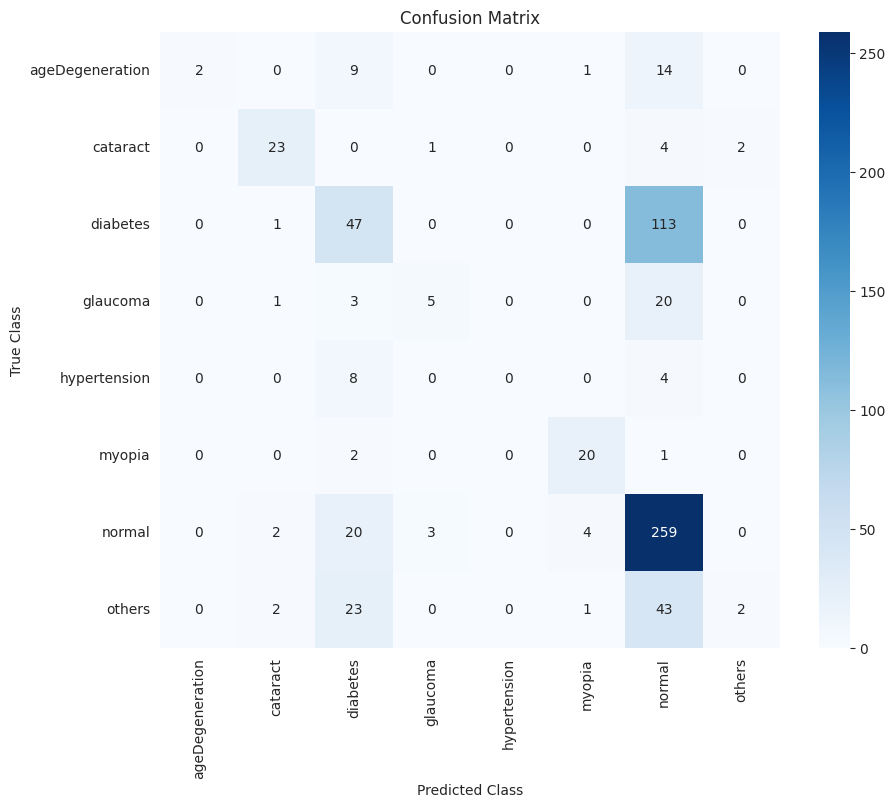

In [ ]:
# #before opti
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Generate Predictions
# true_classes = test_gen.classes  # Extract true labels from test data
# class_labels = list(test_gen.class_indices.keys())  # Extract class labels
# predictions = model.predict(test_gen, steps=len(test_gen), verbose=1)
# predicted_classes = predictions.argmax(axis=1)  # Convert probabilities to predicted class indices

# # Classification Report
# print("Classification Report:")
# print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# # Confusion Matrix
# conf_matrix = confusion_matrix(true_classes, predicted_classes)
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
# plt.title("Confusion Matrix")
# plt.ylabel("True Class")
# plt.xlabel("Predicted Class")
# plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 381ms/step
Classification Report:
                 precision    recall  f1-score   support

ageDegeneration       0.50      0.08      0.13        26
       cataract       0.68      0.87      0.76        30
       diabetes       0.46      0.24      0.32       161
       glaucoma       0.33      0.10      0.16        29
   hypertension       0.00      0.00      0.00        12
         myopia       0.87      0.87      0.87        23
         normal       0.56      0.93      0.70       288
         others       0.00      0.00      0.00        71

       accuracy                           0.56       640
      macro avg       0.43      0.39      0.37       640
   weighted avg       0.47      0.56      0.47       640



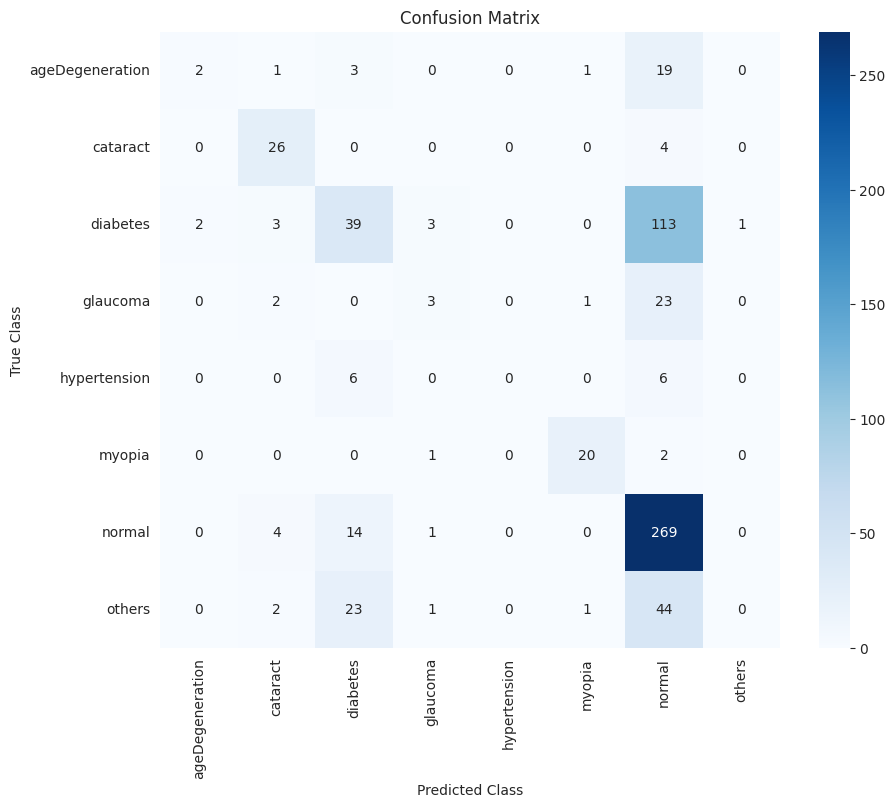

In [ ]:
##after optimizing the model

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate Predictions
true_classes = test_gen.classes  # Extract true labels from test data
class_labels = list(test_gen.class_indices.keys())  # Extract class labels
predictions = model.predict(test_gen, steps=len(test_gen), verbose=1)
predicted_classes = predictions.argmax(axis=1)  # Convert probabilities to predicted class indices

# Classification Report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 434ms/step
Classification Report:
                 precision    recall  f1-score   support

ageDegeneration       0.50      0.08      0.13        26
       cataract       0.68      0.87      0.76        30
       diabetes       0.46      0.24      0.32       161
       glaucoma       0.33      0.10      0.16        29
   hypertension       0.00      0.00      0.00        12
         myopia       0.87      0.87      0.87        23
         normal       0.56      0.93      0.70       288
         others       0.00      0.00      0.00        71

       accuracy                           0.56       640
      macro avg       0.43      0.39      0.37       640
   weighted avg       0.47      0.56      0.47       640



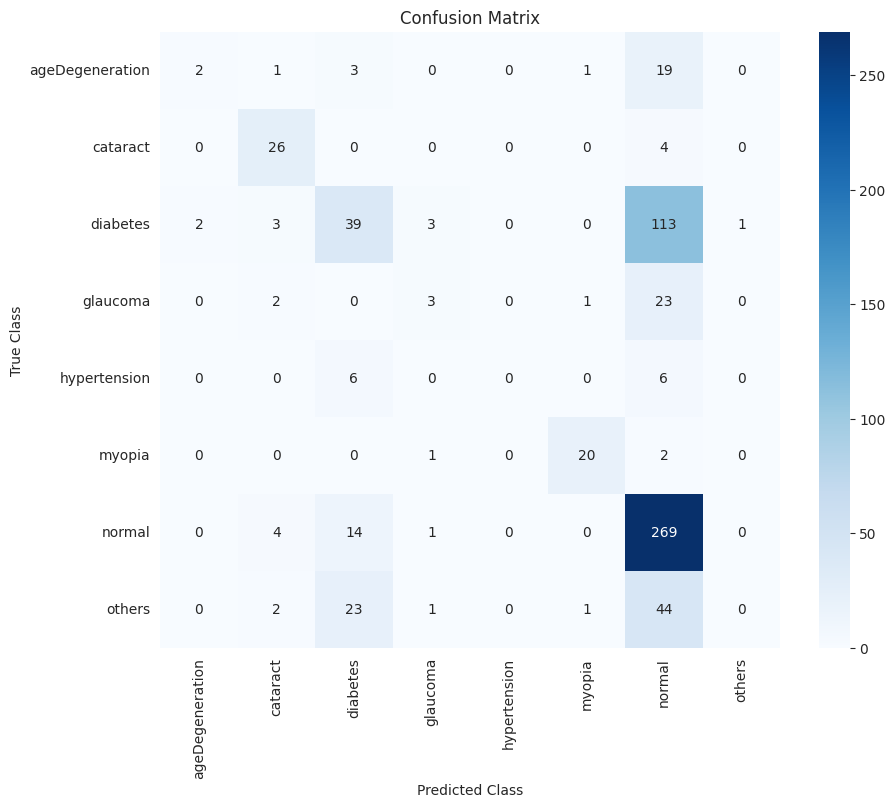

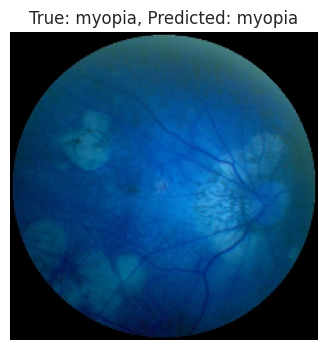

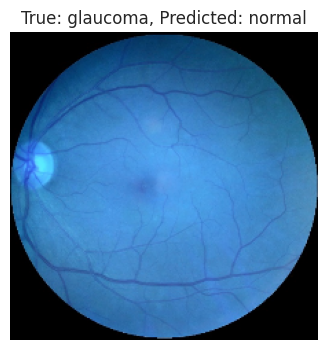

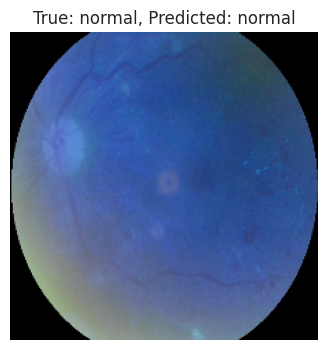

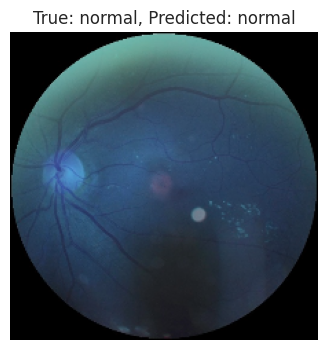

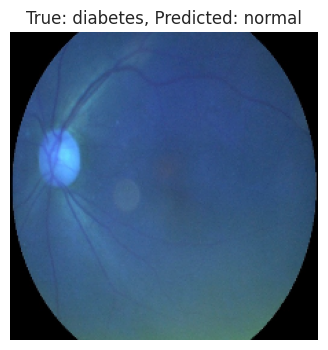

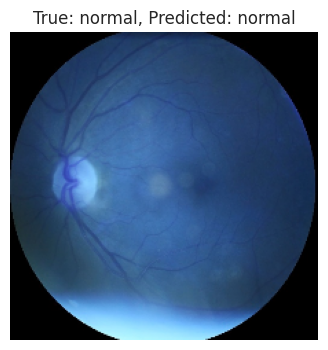

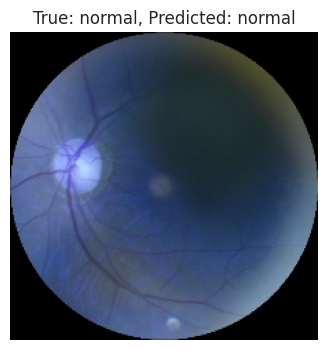

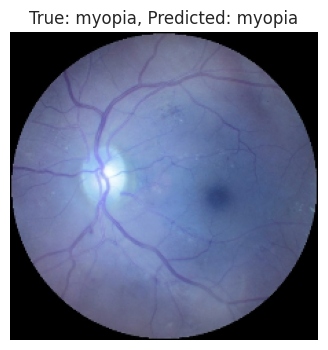

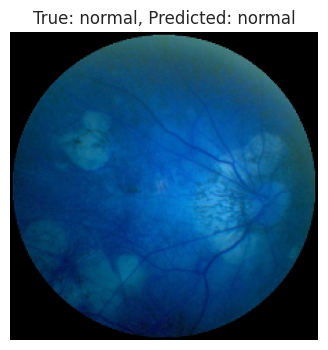

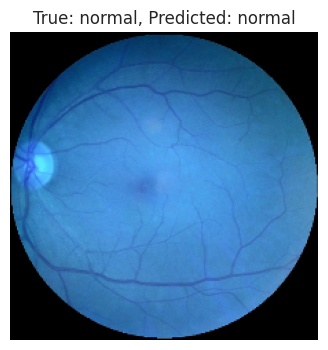

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate Predictions
true_classes = test_gen.classes  # Extract true labels from test data
class_labels = list(test_gen.class_indices.keys())  # Extract class labels
predictions = model.predict(test_gen, steps=len(test_gen), verbose=1)
predicted_classes = predictions.argmax(axis=1)  # Convert probabilities to predicted class indices

# Classification Report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

# Display Images with Predictions
def display_predictions(generator, true_classes, predicted_classes, class_labels, num_images=10):
    generator.reset()  # Reset generator to ensure consistent image order
    for i in range(num_images):
        # Get the next image and true label
        image_batch, label_batch = next(generator)
        image = image_batch[0]  # Extract the first image from the batch
        true_label = class_labels[true_classes[i]]  # Get the true class label
        predicted_label = class_labels[predicted_classes[i]]  # Get the predicted class label

        # Plot the image
        plt.figure(figsize=(4, 4))
        plt.imshow(image.astype("uint8"))
        plt.title(f"True: {true_label}, Predicted: {predicted_label}")
        plt.axis("off")
        plt.show()

# Call the function to display predictions
display_predictions(test_gen, true_classes, predicted_classes, class_labels, num_images=10)


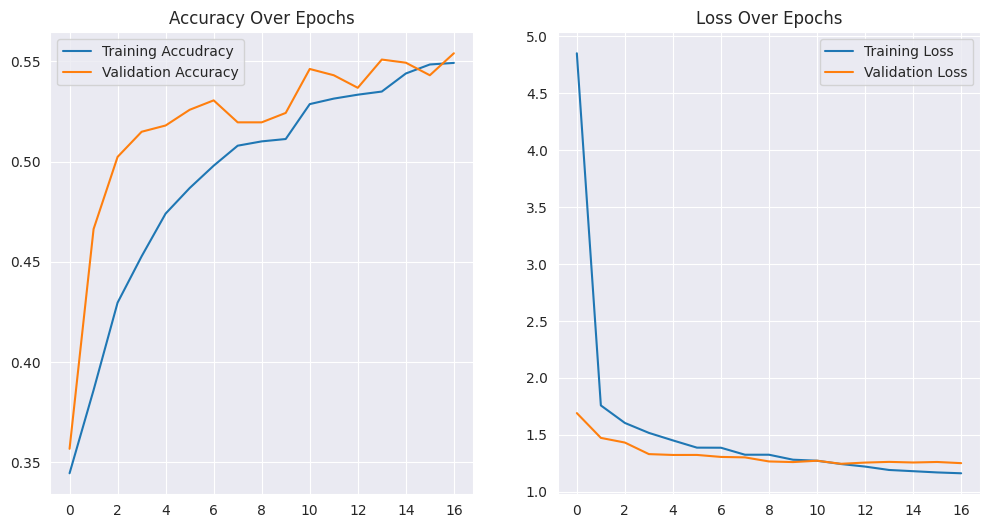

In [ ]:
#before opti model
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accudracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title("Accuracy Over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title("Loss Over Epochs")

    plt.show()

# Plot Training Results
plot_training(history)


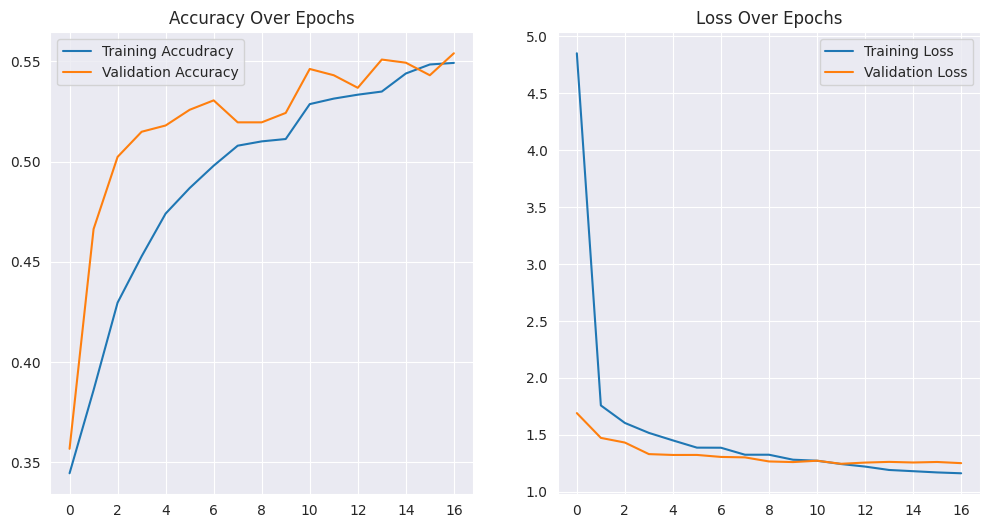

In [ ]:
#after opti
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accudracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title("Accuracy Over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title("Loss Over Epochs")

    plt.show()

# Plot Training Results
plot_training(history)


In [ ]:
# class FocalLoss(nn.Module):
#     def _init_(self, alpha=0.25, gamma=2.0):
#         super(FocalLoss, self)._init_()
#         self.alpha = alpha
#         self.gamma = gamma

#     def forward(self, inputs, targets):
#         BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
#         pt = torch.exp(-BCE_loss)
#         F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
#         return F_loss.mean()

Improving accuracy
(Abhi)


In [ ]:
#sample batch to verify
images, labels = next(train_gen)
print(f"Batch shape: {images.shape}, Labels shape: {labels.shape}")


Batch shape: (40, 224, 224, 3), Labels shape: (40, 8)


#TRYING OUT DIFFERENT LOSSES



In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy

def weighted_bce_loss(weights):
    def loss(y_true, y_pred):
        bce = BinaryCrossentropy()
        return weights[0] * bce(y_true, y_pred) + weights[1] * (1 - y_true) * y_pred
    return loss


In [ ]:
def hill_loss(y_true, y_pred):
    return tf.reduce_mean(-tf.math.log(1 - tf.abs(y_true - y_pred) + 1e-8))


In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy

def weighted_softmax_loss(class_weights):
    def loss(y_true, y_pred):
        weighted_logits = y_true * class_weights
        return CategoricalCrossentropy()(weighted_logits, y_pred)
    return loss


In [ ]:
def weighted_cce_loss(class_weights):
    def loss(y_true, y_pred):
        weights = tf.reduce_sum(class_weights * y_true, axis=-1)
        cce = tf.keras.losses.CategoricalCrossentropy()
        return cce(y_true, y_pred) * weights
    return loss


In [ ]:
def train_model_with_loss(model, loss_fn, train_gen, valid_gen, epochs=5):
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=loss_fn,
        metrics=['accuracy']
    )
    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=epochs,
        steps_per_epoch=len(train_gen),
        validation_steps=len(valid_gen),
        verbose=1
    )
    return history


In [ ]:
# Define class weights (example weights, customize based on dataset distribution)
class_weights = tf.constant([1.2, 0.8, 1.1, 0.9, 1.3, 1.0, 0.7, 1.4], dtype=tf.float32)

# Train the model with each loss function
loss_functions = {
    "Weighted BCE": weighted_bce_loss([0.7, 0.3]),
    "Weighted CCE": weighted_cce_loss(class_weights),
    "Weighted Softmax": weighted_softmax_loss(class_weights),
    "Hill Loss": hill_loss

}

metrics_table = []

for loss_name, loss_fn in loss_functions.items():
    print(f"\nTraining with {loss_name}")
    model = build_model(input_shape=img_shape, num_classes=num_classes)  # Rebuild model for each loss
    history = train_model_with_loss(model, loss_fn, train_gen, valid_gen, epochs=30)

    # Evaluate the model on validation data
    val_loss, val_acc = model.evaluate(valid_gen, steps=len(valid_gen), verbose=1)
    metrics_table.append({"Loss Function": loss_name, "Validation Accuracy": val_acc, "Validation Loss": val_loss})



Training with Weighted BCE
Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 80s 377ms/step - accuracy: 0.4110 - loss: 0.2764 - val_accuracy: 0.4789 - val_loss: 0.7632
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 221ms/step - accuracy: 0.5193 - loss: 0.2129 - val_accuracy: 0.3271 - val_loss: 0.3267
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 228ms/step - accuracy: 0.5550 - loss: 0.1988 - val_accuracy: 0.3020 - val_loss: 0.3163
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step - accuracy: 0.5869 - loss: 0.1858 - val_accuracy: 0.5603 - val_loss: 0.1933
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 217ms/step - accuracy: 0.6134 - loss: 0.1757 - val_accuracy: 0.6244 - val_loss: 0.1676
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 223ms/step - accuracy: 0.6462 - loss: 0.1615 - val_accuracy: 0.5524 - val_loss: 0.1965
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.6535 - loss: 0.1540 - val_accuracy: 0.5696 - val_loss: 0.2237
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step 

In [ ]:
# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics_table)
print(metrics_df)


NameError: name 'pd' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Plot Validation Accuracy
plt.figure(figsize=(12, 6))
plt.bar(metrics_df['Loss Function'], metrics_df['Validation Accuracy'], color='skyblue', edgecolor='black')
plt.title('Validation Accuracy Comparison', fontsize=16, weight='bold')
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
for i, value in enumerate(metrics_df['Validation Accuracy']):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

# Plot Validation Loss
plt.figure(figsize=(12, 6))
plt.bar(metrics_df['Loss Function'], metrics_df['Validation Loss'], color='salmon', edgecolor='black')
plt.title('Validation Loss Comparison', fontsize=16, weight='bold')
plt.ylabel('Loss', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
for i, value in enumerate(metrics_df['Validation Loss']):
    plt.text(i, value + 0.05, f'{value:.2f}', ha='center', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Plot Validation Accuracy
plt.figure(figsize=(12, 6))
plt.bar(metrics_df['Loss Function'], metrics_df['Validation Accuracy'], color='skyblue', edgecolor='black')
plt.title('Validation Accuracy Comparison', fontsize=16, weight='bold')
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
for i, value in enumerate(metrics_df['Validation Accuracy']):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

# Plot Validation Loss
plt.figure(figsize=(12, 6))
plt.bar(metrics_df['Loss Function'], metrics_df['Validation Loss'], color='salmon', edgecolor='black')
plt.title('Validation Loss Comparison', fontsize=16, weight='bold')
plt.ylabel('Loss', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
for i, value in enumerate(metrics_df['Validation Loss']):
    plt.text(i, value + 0.05, f'{value:.2f}', ha='center', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()


In [ ]:


# # SimCLR Model for SSL
# class SimCLR(nn.Module):
#     def _init_(self, base_model):
#         super(SimCLR, self)._init_()
#         self.encoder = nn.Sequential(*list(base_model.children())[:-1])  # Remove final FC
#         self.projection_head = nn.Sequential(
#             nn.Linear(2048, 512),
#             nn.ReLU(),
#             nn.Linear(512, 128)
#         )

#     def forward(self, x):
#         h = self.encoder(x).squeeze()
#         z = self.projection_head(h)
#         return z

# # Data Augmentation for SSL
# ssl_transforms = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
#     transforms.RandomGrayscale(p=0.2),
#     transforms.ToTensor(),
# ])

# # Pretrain SimCLR
# def pretrain_ssl(simclr_model, dataloader, optimizer, epochs):
#     for epoch in range(epochs):
#         simclr_model.train()
#         total_loss = 0
#         for images, _ in dataloader:
#             images = images.to(device)
#             optimizer.zero_grad()

#             # Forward pass through encoder and projection head
#             z = simclr_model(images)
#             loss = compute_ssl_loss(z)  # Implement contrastive loss
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()
#         print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

# # Contrastive Loss for SimCLR
# def compute_ssl_loss(z):
#     # Simplified for clarity. Actual implementation requires batch negative sampling
#     batch_size = z.size(0)
#     z = nn.functional.normalize(z, dim=1)
#     similarity_matrix = torch.matmul(z, z.T)
#     labels = torch.arange(batch_size).to(z.device)
#     loss = nn.CrossEntropyLoss()(similarity_matrix, labels)
#     return loss

# # Fine-tune ResNet for Multilabel Classification
# class MultilabelResNet(nn.Module):
#     def _init_(self, base_model, num_classes):
#         super(MultilabelResNet, self)._init_()
#         self.encoder = nn.Sequential(*list(base_model.children())[:-1])  # Remove FC
#         self.fc = nn.Linear(2048, num_classes)

#     def forward(self, x):
#         x = self.encoder(x).squeeze()
#         x = self.fc(x)
#         return torch.sigmoid(x)

# # Fine-tuning Phase
# def fine_tune_model(model, dataloader, optimizer, loss_fn, epochs):
#     for epoch in range(epochs):
#         model.train()
#         total_loss = 0
#         for images, labels in dataloader:
#             images, labels = images.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = loss_fn(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#         print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

# # Main Execution
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# resnet = resnet50(pretrained=False)
# simclr_model = SimCLR(resnet).to(device)
# optimizer_ssl = optim.Adam(simclr_model.parameters(), lr=0.001)

# # Load ODIR 5K Dataset (Assume ODIR dataset loaded here)
# ssl_dataloader = train_gen  # DataLoader for SSL
# fine_tune_dataloader =   # DataLoader for fine-tuning

# # SSL Pretraining
# pretrain_ssl(simclr_model, ssl_dataloader, optimizer_ssl, epochs=10)

# # Fine-tuning
# multilabel_model = MultilabelResNet(resnet, num_classes=8).to(device)
# optimizer_finetune = optim.Adam(multilabel_model.parameters(), lr=0.0001)
# focal_loss = FocalLoss(alpha=0.25, gamma=2.0)

# fine_tune_model(multilabel_model, fine_tune_dataloader, optimizer_finetune, focal_loss, epochs=10)